# FOMC Analysis
FOMC has eight regular meetings to determine the monetary policy. At each meeting, it publishes press conference minutes, statements as well as scripts in text. In addition to this regular meetings, the members’ speeches and testimonies are also scripted on the website.
At each meeting, the policy makers decide monetary policy and publish the decision along with their view on current economic situation and forecast, including Forward Guidance since 2012. The central banks intend to indicate their potential future monetary policy in their publications as a measure of market communication.
The objective of this project is to apply NLP on those text published by FOMC to find latent features. First, I apply machine learning to economic indices to see how the prediction performs. Then, add pre-processed text data as additional feature in traditional machine learning technique to see if it contains the meaningful information. Finally, apply Deep Learning technique such as LSTM/RNN and BERT to see if these can better predict the rate hike/lower at each FOMC meeting.
All data used in this analysis are publicly available.

<img src='../img/FomcMeetings.png' width=700>

FOMC Meeting documents are available here: https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm

The process followed in this project is dipicted as follows:

<img src='../img/process.png' width=800>

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Use TPU
#if IN_COLAB:
#  # TPU Setting
#  import os
#  assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'  
#  VERSION = "20200220"
#  !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#  !python pytorch-xla-env-setup.py --version $VERSION

In [4]:
# Use GPU
#if IN_COLAB:
#    torch.cuda.get_device_name(0)

In [5]:
# Uninstall existing versions:
#!pip uninstall numpy -y
#!pip uninstall pandas -y
#!pip uninstall tqdm -y
#!pip uninstall torch -y
#!pip uninstall scikit-plot -y
#!pip uninstall transformers -y

# Install packages:
!pip install numpy==1.16.4
!pip install pandas==0.25.0
!pip install torch==1.4.0
!pip install transformers
!pip install tqdm==4.43.0
!pip install scikit-plot

In [6]:
# Python libraries
import datetime as dt
import re
import os
import pickle
from tqdm.notebook import tqdm
import time
import logging
import random
from collections import defaultdict, Counter
from dateutil.relativedelta import *

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Matplotlib style
plt.style.use('fivethirtyeight')
sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_rows = 20
%pprint

Pretty printing has been turned OFF


Run `fomc_get_calendar.py` to scrape FOMC Meeting calenadrs from FOMC wetbiste

In [14]:
#file = open('/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/fomc_calendar.pickle', 'rb')
#calendar_df = pickle.load(file)
calendar_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/fomc_calendar.csv')
calendar_df['RateDecision'] = calendar_df['RateDecision'].apply(lambda x: 'Raise' if x==1 else ('Lower' if x==-1 else 'Hold'))
#file.close()
calendar_df[['ChairPerson', 'RateDecision', 'Rate', 'RateDiff']].iloc[:-3]


,ChairPerson,RateDecision,Rate,RateDiff
0,Paul Volcker,Lower,9.500,-0.500
1,Paul Volcker,Lower,9.000,-0.500
2,Paul Volcker,Hold,8.500,0.000
3,Paul Volcker,Hold,8.500,0.000
4,Paul Volcker,Hold,8.500,0.000
5,Paul Volcker,Hold,8.500,0.000
6,Paul Volcker,Hold,8.500,0.000
7,Paul Volcker,Raise,8.625,0.125
8,Paul Volcker,Hold,8.625,0.000
9,Paul Volcker,Raise,8.750,0.125


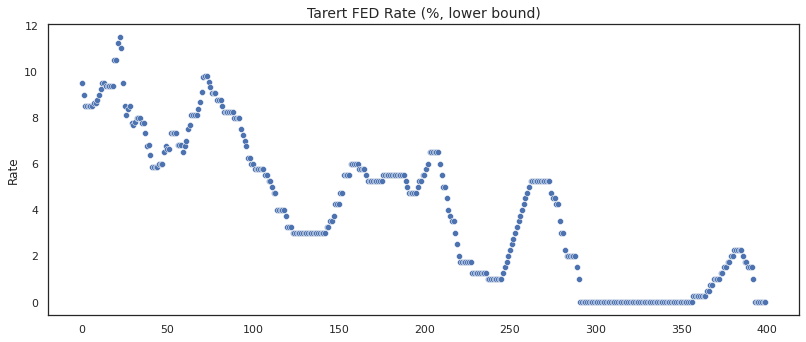

In [15]:
plt.figure(figsize=(12,5))
sns.scatterplot(x=calendar_df.index.get_level_values(0), y=calendar_df['Rate'])
plt.title('Tarert FED Rate (%, lower bound)', fontsize=14)
plt.show()

# 1. Download Economic Indices
Important economic indices are obtained from Economic Research in FRB of St. Louis Website called FRED (https://fred.stlouisfed.org/).
 - FED Target Rates (range)
 - GDP (Real, Real Estimate)
 - CPI / PCE
 - Employment and Unemployment
 - Retail Sales and Home Sales
 - ISM Purchasing Managers Index and Non-manufacturing Index

In [17]:
file = open('/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/nontext_data.pickle', 'rb')
meta_df = pickle.load(file)
file.close()
meta_df.columns

AttributeError: ignored

In [ ]:
fig, axes = plt.subplots(5,4,figsize=(34,24))
sns.lineplot(meta_df['GDP_date'], meta_df['GDP_value'].values, ax=axes[0][0])
sns.lineplot(meta_df['GDP_date'], meta_df['GDP_diff_prev'].values, ax=axes[0][1])
sns.lineplot(meta_df['GDP_date'], meta_df['GDP_diff_year'].values, ax=axes[0][1])
sns.lineplot(meta_df['GDPPOT_date'], meta_df['GDPPOT_value'].values, ax=axes[0][2])
sns.lineplot(meta_df['GDPPOT_date'], meta_df['GDPPOT_diff_prev'].values, ax=axes[0][3])
sns.lineplot(meta_df['GDPPOT_date'], meta_df['GDPPOT_diff_year'].values, ax=axes[0][3])
sns.lineplot(meta_df['PCE_date'], meta_df['PCE_value'].values, ax=axes[1][0])
sns.lineplot(meta_df['PCE_date'], meta_df['PCE_diff_prev'].values, ax=axes[1][1])
sns.lineplot(meta_df['PCE_date'], meta_df['PCE_diff_year'].values, ax=axes[1][1])
sns.lineplot(meta_df['CPI_date'], meta_df['CPI_value'].values, ax=axes[1][2])
sns.lineplot(meta_df['CPI_date'], meta_df['CPI_diff_prev'].values, ax=axes[1][3])
sns.lineplot(meta_df['CPI_date'], meta_df['CPI_diff_year'].values, ax=axes[1][3])
sns.lineplot(meta_df['Unemp_date'], meta_df['Unemp_value'].values, ax=axes[2][0])
sns.lineplot(meta_df['Unemp_date'], meta_df['Unemp_diff_prev'].values, ax=axes[2][1])
sns.lineplot(meta_df['Unemp_date'], meta_df['Unemp_diff_year'].values, ax=axes[2][1])
sns.lineplot(meta_df['Employ_date'], meta_df['Employ_value'].values, ax=axes[2][2])
sns.lineplot(meta_df['Employ_date'], meta_df['Employ_diff_prev'].values, ax=axes[2][3])
sns.lineplot(meta_df['Employ_date'], meta_df['Employ_diff_year'].values, ax=axes[2][3])
sns.lineplot(meta_df['PMI_date'], meta_df['PMI_value'].values, ax=axes[3][0])
sns.lineplot(meta_df['PMI_date'], meta_df['PMI_diff_prev'].values, ax=axes[3][1])
sns.lineplot(meta_df['PMI_date'], meta_df['PMI_diff_year'].values, ax=axes[3][1])
sns.lineplot(meta_df['NMI_date'], meta_df['NMI_value'].values, ax=axes[3][2])
sns.lineplot(meta_df['NMI_date'], meta_df['NMI_diff_prev'].values, ax=axes[3][3])
sns.lineplot(meta_df['NMI_date'], meta_df['NMI_diff_year'].values, ax=axes[3][3])
sns.lineplot(meta_df['Rsales_date'], meta_df['Rsales_value'].values, ax=axes[4][0])
sns.lineplot(meta_df['Rsales_date'], meta_df['Rsales_diff_prev'].values, ax=axes[4][1])
sns.lineplot(meta_df['Rsales_date'], meta_df['Rsales_diff_year'].values, ax=axes[4][1])
sns.lineplot(meta_df['Hsales_date'], meta_df['Hsales_value'].values, ax=axes[4][2])
sns.lineplot(meta_df['Hsales_date'], meta_df['Hsales_diff_prev'].values, ax=axes[4][3])
sns.lineplot(meta_df['Hsales_date'], meta_df['Hsales_diff_year'].values, ax=axes[4][3])

for i in range(len(axes)):
    for j in range(len(axes[i])):
        axes[i][j].set_xlabel("")
        if (j == 1) | (j == 3):
            axes[i][j].legend(['Previous Period', 'Previous Year'])

axes[0][0].set_title('Real GDP ($b)')
axes[0][1].set_title('Real GDP (% growth)')
axes[0][2].set_title('Potential GDP ($b)')
axes[0][3].set_title('Potential GDP (% growth)')
axes[1][0].set_title('PCE')
axes[1][1].set_title('PCE (% change)')
axes[1][2].set_title('CPI')
axes[1][3].set_title('CPI (% change)')
axes[2][0].set_title('Unemployment Rate (%)')
axes[2][1].set_title('Unemployment Rate (% change)')
axes[2][2].set_title('Employment (persons)')
axes[2][3].set_title('Employment (% change)')
axes[3][0].set_title('PMI')
axes[3][1].set_title('PMI (% change)')
axes[3][2].set_title('NMI')
axes[3][3].set_title('NMI (% change)')
axes[4][0].set_title('Retail Sales ($m)')
axes[4][1].set_title('Retail Sales (% growth)')
axes[4][2].set_title('Housing Sales ($m)')
axes[4][3].set_title('Housing Sales (% growth)')


#ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.tight_layout(pad=2.0)
plt.show()

# 2. Scraping FOMC Website
Run `fomc_get_data.py` to crawl and download texts from the wetbiste
<img src="../img/FomcWebsite.png" width="800">

### Sample statement

In [ ]:
file = open('C:/Users/theon/Desktop/proj2/data/preprocessed/text_no_split.pickle', 'rb')
text_df = pickle.load(file)
file.close()

In [ ]:
print(text_df.loc[text_df['type']=='statement']['date'].iloc[-2].strftime('%Y-%m-%d'))
print('------------')
print(text_df.loc[text_df['type']=='statement']['text'].iloc[-2].replace(". ", ".\n\n"))

### Sample minutes

In [ ]:
print(text_df.loc[text_df['type']=='minutes']['date'].iloc[-1].strftime('%Y-%m-%d'))
print('------------')
print(text_df.loc[text_df['type']=='minutes']['text'].iloc[-1].replace(". ", ".\n\n"))

In [ ]:
print(text_df.loc[text_df['type']=='press_conference']['date'].iloc[-1].strftime('%Y-%m-%d'))
print('------------')
print(text_df.loc[text_df['type']=='press_conference']['text'].iloc[-1].replace(". ", ".\n\n"))

In [ ]:
kwargs={'label': [1,2,3,4,5,6]}
plt.figure(figsize=(10,5))
sns.countplot(x='type', data=text_df.groupby(by=['type', 'date']).count().reset_index(),
             order=['statement', 'minutes', 'press_conference', 'meeting_script', 'speech', 'testimony'], **kwargs)
plt.title('The number of text data', fontsize=16)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15,10))
sns.distplot(text_df.loc[text_df['type'] == 'statement']['word_count'], bins=20, ax=axes[0][0], kde=False, color='r')
sns.distplot(text_df.loc[text_df['type'] == 'minutes']['word_count'], bins=20, ax=axes[0][1], kde=False, color='y')
sns.distplot(text_df.loc[text_df['type'] == 'press_conference']['word_count'], bins=20, ax=axes[1][0], kde=False, color='g')
sns.distplot(text_df.loc[text_df['type'] == 'meeting_script']['word_count'], bins=20, ax=axes[1][1], kde=False, color='b')
sns.distplot(text_df.loc[text_df['type'] == 'speech']['word_count'], bins=20, ax=axes[2][0], kde=False, color='purple')
sns.distplot(text_df.loc[text_df['type'] == 'testimony']['word_count'], bins=20, ax=axes[2][1], kde=False, color='orange')
axes[0][0].set_title("Statement", fontsize=14)
axes[0][1].set_title("Minutes", fontsize=14)
axes[1][0].set_title("Press Conference Script", fontsize=14)
axes[1][1].set_title("Meeting Script", fontsize=14)
axes[2][0].set_title("Speech", fontsize=14)
axes[2][1].set_title("Testimony", fontsize=14)
fig.tight_layout(pad=3.0)
plt.show()

# 3. Preliminary Analysis of Statement Sentiment by Lexicon
Analyse statement by Loughran and McDonald word list to see if the relationship between economy and net sentiment.

The detail analysis can be found on `1_FOMC_Analysis_Preliminary.ipynb`

In [ ]:
file = open("C:/Users/theon/Desktop/proj2/data/train_data/text_df.pickle", "rb")
Data = pickle.load(file)
file.close()

In [ ]:
Data.columns

In [ ]:
stmt_df = Data.loc[Data['type']=='statement'].sort_values(['date']).set_index('date')

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(stmt_df[['n_pos_words', 'n_neg_words']]) 
plt.title('Sentiment over years by Loughran and McDonald lexicon', fontsize=14)
plt.legend(['Count of Positive Words', 'Count of Negative Words'])
ax.grid(True)

plt.show()

In [ ]:
DotCom = np.logical_and(stmt_df.index > '2000-03', stmt_df.index < '2002-10') #Dot-com bubble
OhEight = np.logical_and(stmt_df.index > '2007-04', stmt_df.index < '2009-03') #Financial crisis of 2007–2008
EuroDebt = np.logical_and(stmt_df.index > '2010-09', stmt_df.index < '2012-09') #European debt crisis
Asian = np.logical_and(stmt_df.index > '2015-01', stmt_df.index < '2016-06') #2015–16 Chinese stock market turbulence
Corona = np.logical_and(stmt_df.index > '2020-03', stmt_df.index < '2020-12') #Coronavirus
Recessions = np.logical_or.reduce((DotCom, OhEight, EuroDebt, Asian, Corona))

Greenspan = np.logical_and(stmt_df.index > '1987-08-11', stmt_df.index < '2006-01-31')
Bernanke = np.logical_and(stmt_df.index > '2006-02-01', stmt_df.index < '2014-01-31')
Yellen = np.logical_and(stmt_df.index > '2014-02-03', stmt_df.index < '2018-02-03')
Powell = np.logical_and(stmt_df.index > '2018-02-05', stmt_df.index < '2022-02-05')
chair = np.logical_or.reduce((Greenspan, Yellen))


In [ ]:
Window = 8
CompToMA = stmt_df['tone_score'].rolling(Window).mean()

fig, ax = plt.subplots(figsize=(17,7))
sns.scatterplot(x=stmt_df.index.get_level_values(0), y=stmt_df['rate'], ax=ax)
ax2 = ax.twinx() 
ax2.plot(stmt_df.index, CompToMA, c = 'r', linewidth= 2.0)
ax.legend(['Fed Funds Target Rate (%)'], loc=2, fontsize=14)
ax2.legend(['Sentiment Score (moving average)'], loc=1, fontsize=14)
ax.set_xlim('1996-12', '2020-12')
ax.set_ylim(-4, 8)
ax2.set_ylim(-4, 8)
ax.grid(True)

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(stmt_df.index, 0, 10, where = chair, facecolor='lightblue', alpha=0.5, transform=trans)
ax.fill_between(stmt_df.index, 0, 10, where = recessions, facecolor='grey', alpha=0.5, transform=trans)

props = dict(boxstyle='round', facecolor='skyblue', alpha=0.2)
ax.text(0.15, -0.1, "Alan Greenspan", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.50, -0.1, "Ben Bernanke", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.75, -0.1, "Janet Yellen", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.90, -0.1, "Jerome Powell", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.14, 0.85, "Dot-com bubble", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.43, 0.85, "Financial crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.57, 0.85, "European debt \n crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.75, 0.85, "China stock \n turbulence", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.95, 0.85, "Covid-19", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


arrow_style = dict(facecolor='black', shrink=0.05)
ax.annotate('QE1', xy=('2008-11-25', 0), xytext=('2008-11-25', -3.5), size=16, ha='center', arrowprops=arrow_style)
ax.annotate('QE2', xy=('2010-11-03', 0), xytext=('2010-11-03', -3.5), size=16, ha='center', arrowprops=arrow_style)
ax.annotate('QE3', xy=('2012-09-13', 0), xytext=('2012-09-13', -3.5), size=16, ha='center', arrowprops=arrow_style)
ax.annotate('Tapering', xy=('2013-12-18', 0), xytext=('2013-12-18', -3.5), size=16, ha='center', arrowprops=arrow_style)

plt.title('Net Sentiment with Fed Rates, Resession and Chairpersons', fontsize=16)
plt.show()

# 4. Process economic indices data
The details can be found on `2_FOMC_Analysis_Preprocess_NonText.ipynb` and `4_FOMC_Analysis_EDA_NonText.ipynb`

## Taylor Rule
As a part of feature engineering, calculate taylor rules and see whether the first derivatives and difference from FED rate could be used. FED has released how policymakers use economic indices data, so try to calculate them from raw data. <BR />
https://www.federalreserve.gov/monetarypolicy/policy-rules-and-how-policymakers-use-them.htm

<img src='../img/taylor_rule.png' width="800">

In [ ]:
taylor=meta_df[['Rate', 'Taylor', 'Balanced', 'Inertia']]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=taylor, dashes=False, lw=2, ax=ax1)
ax1.grid(True)
ax1.set_title('Actual FED Rate and calculated rates', fontsize=14)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel('Rate (%)', fontsize=14)
ax1.legend(['FED Rate', 'Taylor Rule', 'Balanced Rule', 'Intertia Rule'])
sns.heatmap(taylor.astype(float).corr(), cmap="coolwarm", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title('Correlation between the rates are quite high', fontsize=14)
plt.show()

## Select features from meta data
Create moving average over different period, check correlation with Rate Decision (Raise/Hold/Lower) and select which features would be used as inputs for training. Also, impute the missing values.

In [ ]:
corr_columns = ['RateDecision', 'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

fig, ax = plt.subplots(1, 1, figsize=(17, 10))

sns.heatmap(meta_df[corr_columns].astype(float).corr(), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1, ax=ax)
ax.set_title("Correlation between Rate Decision and Economic Indices", fontsize=14)
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(meta_df['PMI_value'][(meta_df["RateDecision"] == -1) & (meta_df['PMI_value'].notnull())], ax=ax1, color="Red", shade=True)
sns.kdeplot(meta_df['PMI_value'][(meta_df["RateDecision"] == 0) & (meta_df['PMI_value'].notnull())], ax=ax1, color="Gray", shade=True)
sns.kdeplot(meta_df['PMI_value'][(meta_df["RateDecision"] == 1) & (meta_df['PMI_value'].notnull())], ax=ax1, color="Green", shade=True)
ax1.set_xlabel('PMI')
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution for PMI Value", fontsize=14)
ax1.legend(["Lower", "Hold", "Raise"])
sns.kdeplot(meta_df['PCE_diff_prev'][(meta_df["RateDecision"] == -1) & (meta_df['PCE_diff_prev'].notnull())], ax=ax2, color="Red", shade=True)
sns.kdeplot(meta_df['PCE_diff_prev'][(meta_df["RateDecision"] == 0) & (meta_df['PCE_diff_prev'].notnull())], ax=ax2, color="Gray", shade=True)
sns.kdeplot(meta_df['PCE_diff_prev'][(meta_df["RateDecision"] == 1) & (meta_df['PCE_diff_prev'].notnull())], ax=ax2, color="Green", shade=True)
ax2.set_xlabel('PCE % Change ')
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution for PCE % Change from privious period", fontsize=14)
ax2.legend(["Lower", "Hold", "Raise"])
plt.show()


# 5. Process text data
The details can be found in `3_FOMC_Analysis_Preprocess_Text.ipynb`

<img src="../img/text_process.png" width="800" align="left">

In [ ]:
file = open("C:/Users/theon/Desktop/proj2/data/train_data/train_df.pickle", "rb")
train_df = pickle.load(file)
file.close()

In [ ]:
file = open("C:/Users/theon/Desktop/proj2/data/FOMC/statement.pickle", "rb")
statement_df = pickle.load(file)
file.close()
print(statement_df.iloc[-2]['contents'].replace("\n[SECTION]\n", ""))

In [ ]:
print(stmt_df.loc['2020-04-29']['text'])

In [ ]:
print(stmt_df.loc['2020-04-29']['tokenized'])

In [ ]:
print(stmt_df.loc['2020-04-29']['token_ids'])

# 6. Build and Train Models
Take textual inputs and meta inputs to predict three classes: Raise, Hold or Lower
<img src="../img/model_overview.png" width="900">

The models are the same as Financial News / Tweets sentiment analysis but include meta inputs and concatinate them.
<img src="../img/models_1.png" width="900">
<img src="../img/models_2.png" width="900">
<img src="../img/models_3-2.png" width="900">

# Final Result

Due to the nature of long text per data and very small data set availability, the result was different from financial news and tweets analysis.
Simple lexicon approach with cosine similarity works well and better than more complex models as complex ones could not learn enough with limited data.
Finally, use of the trained BERT model to extract sentence-wise sentiment as inputs to the classification task outperformed the lexicon approach, which shows the sentiment analysis by BERT model could provide some meaningful insight to predict the FOMC decision.

As a future work, there're two main areas to improve:
1. Tackle the lack of enough training data - The models have clearly overfitted to train samples and failed to generalize well, espicially boosting algorithms are prone to overfitting. Hyperparameter tuning and imputation was considered there. In addition, configuraing the model and splitting data to augument the training data by synthetic approach could potentially benefitial. 
2. Improve input text quality - The input texts contain a lot of irrelevant paragraphs, which have nothing to to with FED target rate decision. For example, there are information about regulations, organisation structure and infrastructures. Filtering out less relevant inputs will improve the accuracy of the model prediction as well as training efficiency.

In [ ]:
final_result_dict = {
    'model': ["Baseline"]*2 + ["A: Cosine Similarity"]*2 + ["B: Tfidf"]*2 + ["C: LSTM"]*2 + ["D: LSTM + GloVe"]*2 + ["E: BERT"]*2 + ["F: Prediction by BERT"]*2,
    'metrics': ["Accuracy", "F1 Score"]*7,
    'score': [0.63, 0.50] + [0.78, 0.67] + [0.67, 0.33] + [0.54, 0.24] + [0.63, 0.41] + [0.59, 0.25] + [0.82, 0.73]
}
final_result = pd.DataFrame(final_result_dict)

In [ ]:
plt.figure(figsize=(12, 7))
g = sns.barplot(x='model', y='score', hue='metrics', data=final_result)
for index, row in final_result.loc[final_result['metrics']=='Accuracy'].iterrows():
    g.text(index/2-0.2, row.score+0.01, row.score, color='black', ha="center")
for index, row in final_result.loc[final_result['metrics']=='F1 Score'].iterrows():
    g.text(index/2-0.3, row.score+0.01, row.score, color='black', ha="center")
plt.show()
